In [66]:
import os
import re
import networkx as nx 
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.stats import gaussian_kde

import sys
sys.path.append('../mchem_functions/')
import multivariate_functions as mvf
import PCA_functions as pcf
import ms_functions_and_defs as msf

In [67]:
replicates = 0
replicate_column = 'replicate_y/n'
binary = 1
norm = 0
samples_to_exclude = ['SRFA','HM-B-Win1','AM-A-Win1','HM-PL-Win1','HM-G-Win1']
molecules_to_exclude = ['C17H28O3S1','C18H30O3S1','C19H32O3S1','C16H26O3S1']

In [68]:
ms_data_dir = '../../Data/MS_data'
ord_table_csv = 'CSV_files/processed_csv_data_dir/overall_intensity_ordination_table.csv'

In [69]:
try: os.chdir(ms_data_dir)
except FileNotFoundError: pass

In [70]:
ord_table_df = pd.read_csv(ord_table_csv,index_col=0)
ord_table_df = ord_table_df[ord_table_df[replicate_column]==replicates]
ord_table_df = ord_table_df.drop(columns=replicate_column)

In [71]:
sample_names = list(ord_table_df.index)
for sample in samples_to_exclude:
    for sample2 in [name for name in sample_names if sample in name]:
        sample_names.remove(sample2)
ord_table_df = ord_table_df.loc[sample_names]

ord_table_df = ord_table_df.drop(columns=molecules_to_exclude)
formulae = np.array(ord_table_df.columns)

# ord_table_df

In [72]:
sample_info = {
    'Site': [],
    'Letter': [],
    'Season': [],
    'Type': [],
}

for name in sample_names:
    if 'SRFA' in name.upper():
        sample_info['Site'].append('NA')
        sample_info['Letter'].append('NA')
        sample_info['Season'].append('NA')
        sample_info['Type'].append('SRFA')

    else:
        name = name.split('-')
        sample_info['Site'].append(name[0])
        sample_info['Letter'].append(name[1])
        sample_info['Season'].append(name[2])
        if 'PL' in name:
            sample_info['Type'].append('PL')
        else:
            sample_info['Type'].append('PW')

for info in sample_info:
    sample_info[info] = np.array(sample_info[info])
# sample_info

In [73]:
# set NaN to 0
ord_table_df = ord_table_df.fillna(0)

# remove formulae where the entire column is zeros
formulae = formulae[~np.all(ord_table_df.to_numpy()==0,axis=0)]
ord_table_df = ord_table_df[formulae]

ord_table_arr = ord_table_df.to_numpy()

In [74]:
# pd.DataFrame(ord_table_arr)

In [75]:
def BrayCurtis_diss_matr(matrix):

    dist_stacked = []

    S = np.sum(matrix,axis=1)

    for i in range(np.shape(matrix)[0]):
        dist_row = []

        for j in range(np.shape(matrix)[0]):
            C_ij = np.sum(np.min(matrix[[i,j],:],axis=0))
            dist_row.append( 1-( 2*C_ij / (S[i]+S[j]) ) )

        dist_stacked.append(dist_row)
    
    return np.array(dist_stacked)

def formula_dic(str:str):
    '''Indicate with 1 when there is only 1 of a certain atom: H2O would be "H2O1"'''

    elements = re.findall(r'[a-zA-Z]+', str)
    numbers = re.findall(r'[0-9]+', str)
    
    assert len(elements) == len(numbers), 'the number of elements and the number of indeces should match. Indicate with 1 when there is only 1 of a certain atom: H2O would be "H2O1"'

    dic = {}
    for i in range(len(numbers)):
        n = float(numbers[i])
        if n == int(n): n = int(n)
        dic[elements[i]] = int(n)
    
    return dic

def formula_str_plt(dic:dict):
    str = ''
    for e in dic:
        str += f'{e}'
        if dic[e] > 1:
            str += f'$_{{{dic[e]}}}$'
    return str

def matr_colormesh(arr,x=[],y=[],cmap='Grays'):
    fig, ax = plt.subplots()

    mappable = ax.pcolormesh(arr,cmap=cmap)
    fig.colorbar(mappable)

    ax.set_ylim(np.max(ax.get_ylim()),np.min(ax.get_ylim()))

    if len(x) != 0:
        locationsx = np.arange(len(x))+0.5
        ax.set_xticks(locationsx, x, rotation=90, ha='center')
    if len(y) != 0:
        locationsy = np.arange(len(y))+0.5
        ax.set_yticks(locationsy, y)

In [76]:
if binary:
    ord_table_arr[np.where(ord_table_arr>0)] = 1
if norm:
    ord_table_arr = mvf.standardise(ord_table_arr)

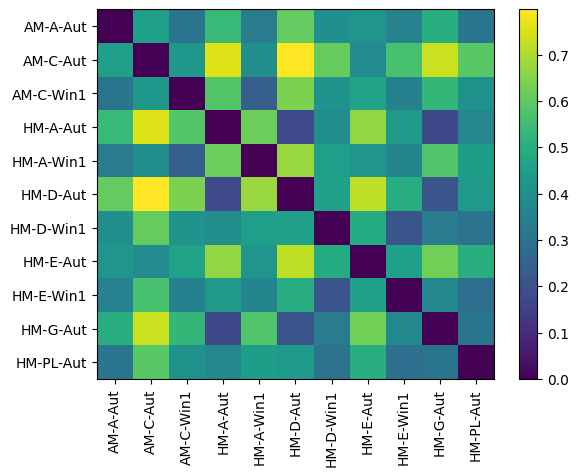

In [77]:
sample_sum = np.sum(ord_table_arr,axis=1)
sample_sum = np.reshape(sample_sum,(len(sample_sum),1))
highest_peak = np.max(ord_table_arr,axis=1)
highest_peak = np.reshape(highest_peak,(len(highest_peak),1))

sum_norm_ord_table_arr = ord_table_arr / highest_peak # or /sample_sum

BC_matrix = BrayCurtis_diss_matr(sum_norm_ord_table_arr)

matr_colormesh(BC_matrix,x=sample_names,y=sample_names,cmap='viridis')

In [78]:
eigvals, _, loadings, coordinates, proportion_explained = mvf.PCoA(BC_matrix,ord_table_arr,number_of_dimensions=6)

Text(0.5, 0, 'Principal coordinate')

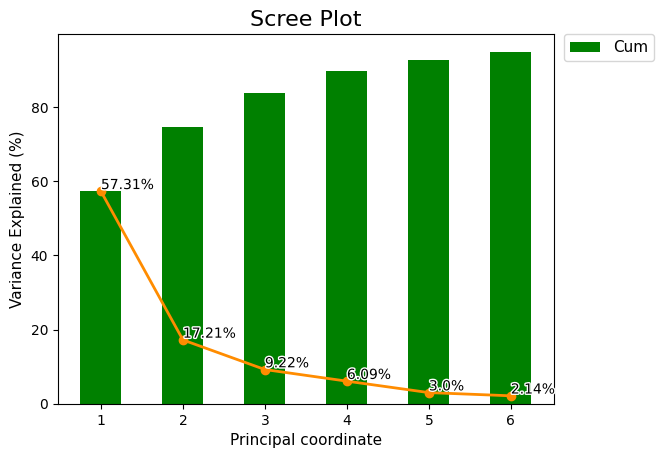

In [79]:
fig_scree, ax_scree = plt.subplots()
pcf.scree_plot(np.arange(1,len(eigvals)+1),proportion_explained,ax=ax_scree)
ax_scree.set_xlabel(f'Principal coordinate')

In [80]:
chosen_PCos = [1,2]

In [81]:
m_shape = {
    'Hare Moss': 'o',
    'Auchencorth Moss': 's',
}

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

In [82]:
sitelong = [{'AM':'Auchencorth Moss','HM':'Hare Moss'}[site] for site in sample_info['Site']]
sample_info['sitelong'] = np.array(sitelong)

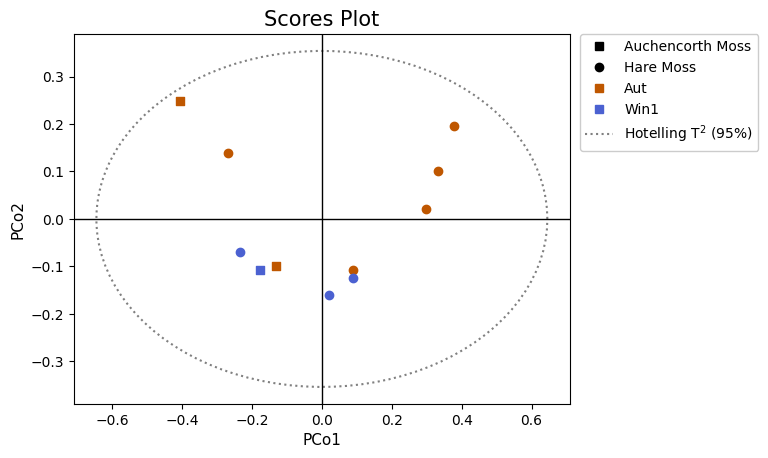

In [83]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(sample_info['sitelong']):
    for season in np.unique(sample_info['Season']):

        idx = np.where((sample_info['sitelong'] == site)&(sample_info['Season'] == season))

        pcf.scores_plot(coordinates[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape[site],c=seasonal_colours[season])
        
pcf.Hotelling(coordinates,chosen_PCos,ax_scores,zorder=-1)

f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(sample_info['sitelong']):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for season in np.unique(sample_info['Season']):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]}')
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]}')

ax_scores.set_title(f'Scores Plot',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig(f'plots/pcoa_plots/scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


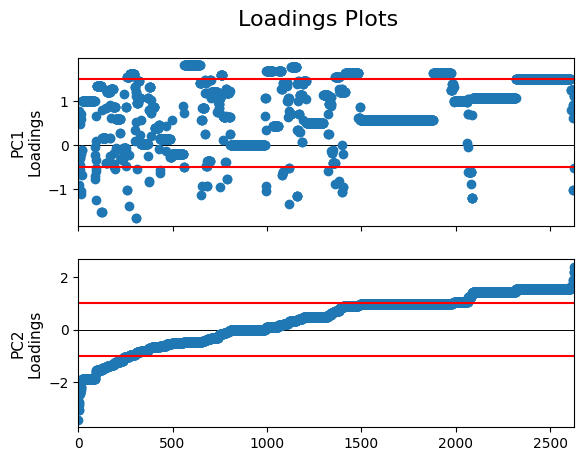

In [84]:
fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(chosen_PCos),sharex=True)

loadings_order_idx = np.argsort(loadings[:,1])

pcf.loadings_plot(np.arange(len(formulae)),loadings[loadings_order_idx],chosen_PCos,ax=ax_loadings,linestyle='',fig=fig_loadings,
                  marker='o')

loadings_thresholds = [[-.5,1.5],
                       [-1,1]]

for i in range(len(chosen_PCos)):
    ax_loadings[i].axhline(np.max(loadings_thresholds[i]),c='r')
    ax_loadings[i].axhline(np.min(loadings_thresholds[i]),c='r')


In [85]:
a = np.array([1,6,4,3,8,2])
np.sort(a)

array([1, 2, 3, 4, 6, 8])

In [86]:
formulae_to_consider = formulae[np.where((loadings[:,chosen_PCos[0]-1]>.8*np.max(loadings[:,chosen_PCos[0]-1]))|
                                         (loadings[:,chosen_PCos[0]-1]<.8*np.min(loadings[:,chosen_PCos[0]-1]))|
                                         (loadings[:,chosen_PCos[1]-1]>.8*np.max(loadings[:,chosen_PCos[1]-1]))|
                                         (loadings[:,chosen_PCos[1]-1]<.8*np.min(loadings[:,chosen_PCos[1]-1])))]

In [87]:
elems = {'C':[],'H':[],'N':[],'O':[],'S':[]}

for f in formulae:
    e_dict_f = msf.MolecFormulaDict(f)
    for e in elems:
        if e in e_dict_f:
            elems[e].append(e_dict_f[e])
        else:
            elems[e].append(0)

In [88]:
elems_df = pd.DataFrame(elems)
elems_df['formulae'] = formulae

In [89]:
elems_df['H/C'] = elems_df['H'] / elems_df['C']
elems_df['O/C'] = elems_df['O'] / elems_df['C']
molecclass_dict = msf.molecclass(elems_df)

In [90]:
idx_to_consider = np.where((loadings[:,chosen_PCos[0]-1]>.8*np.max(loadings[:,chosen_PCos[0]-1]))|
                           (loadings[:,chosen_PCos[0]-1]<.8*np.min(loadings[:,chosen_PCos[0]-1])))

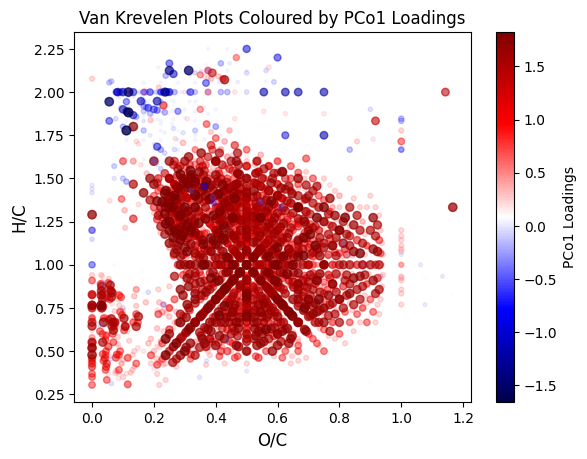

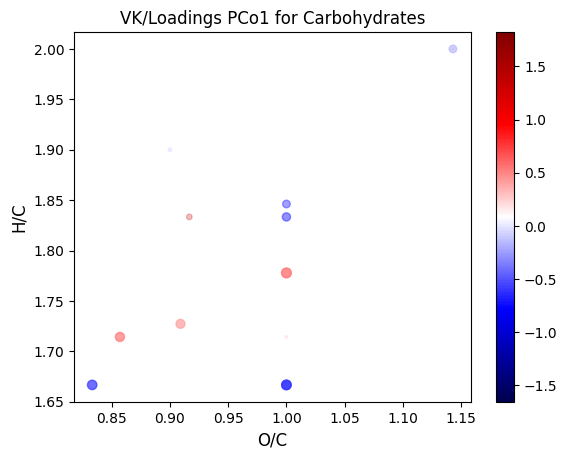

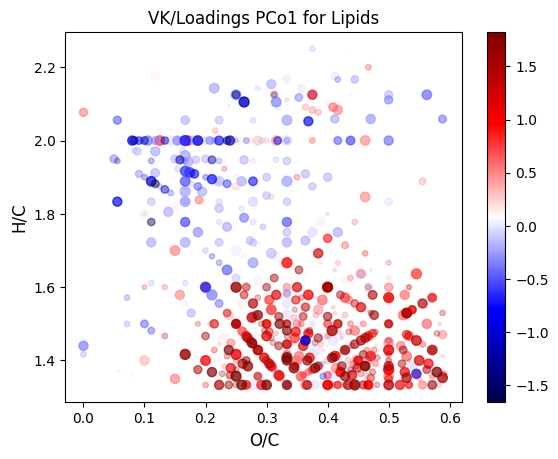

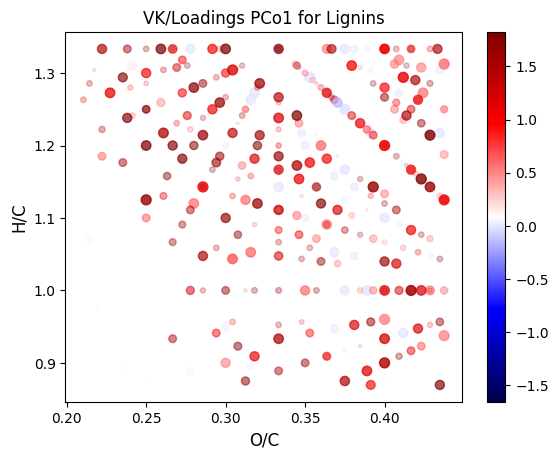

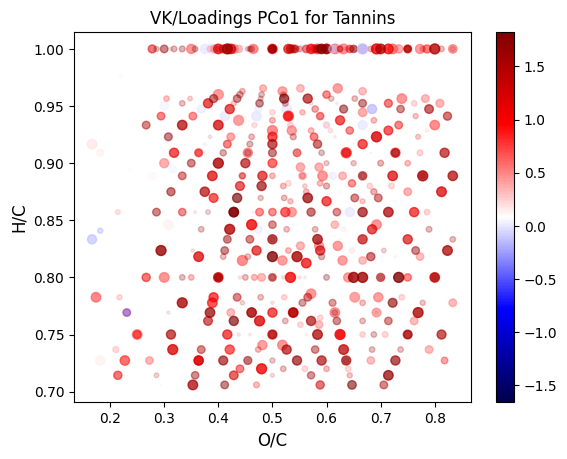

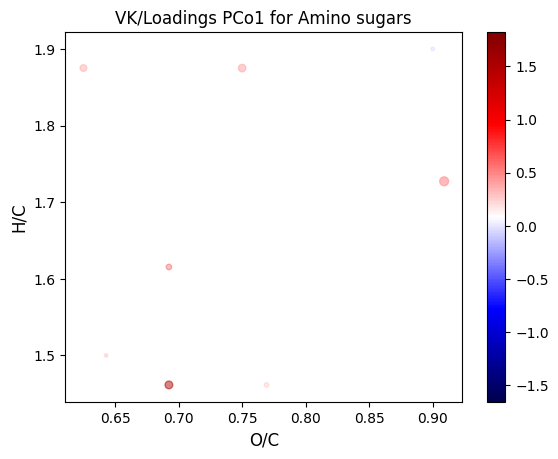

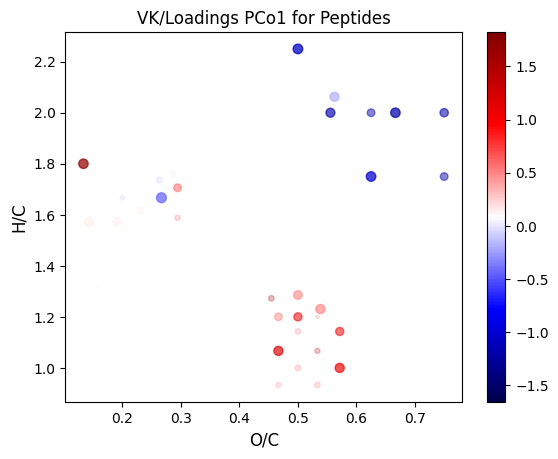

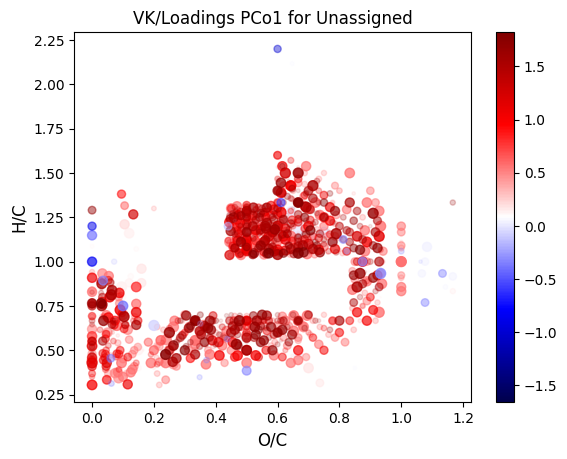

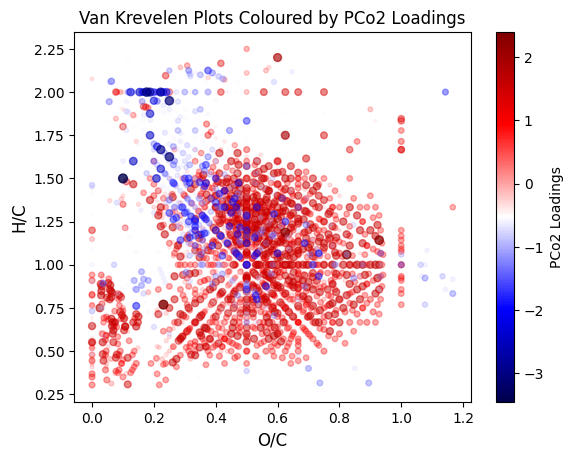

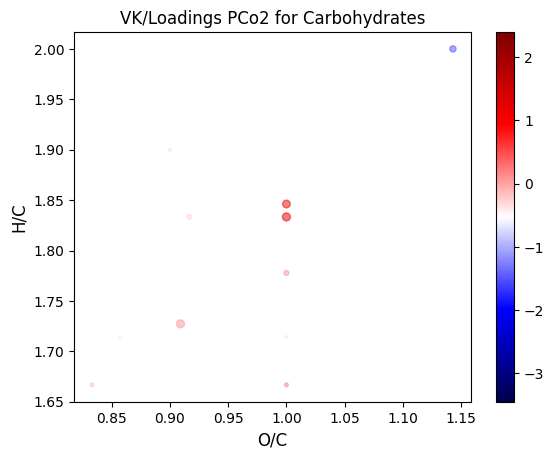

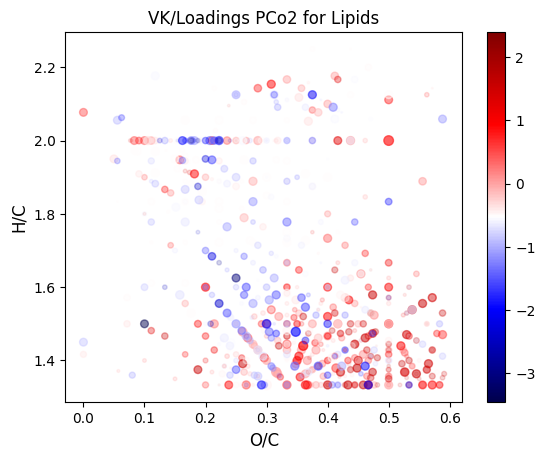

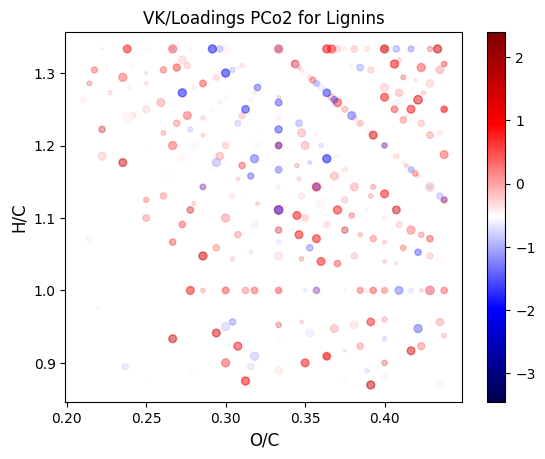

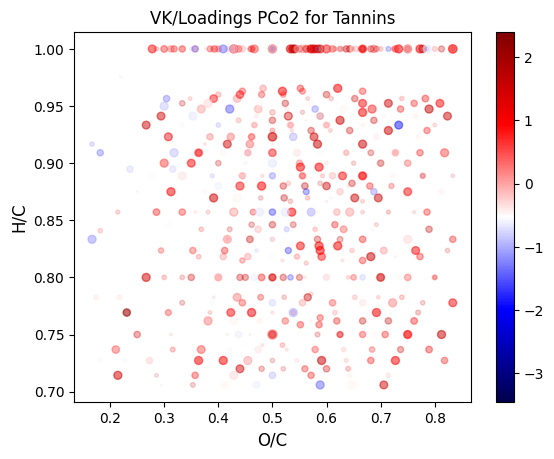

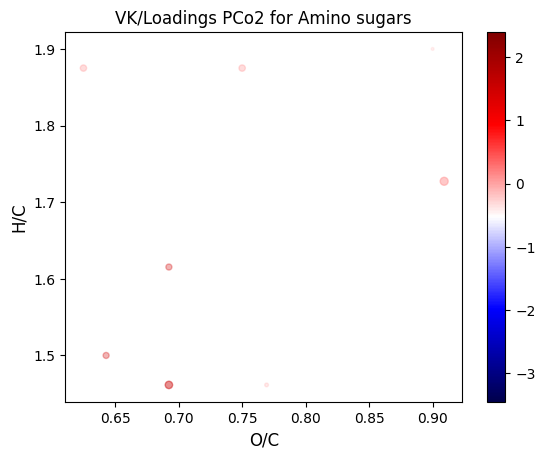

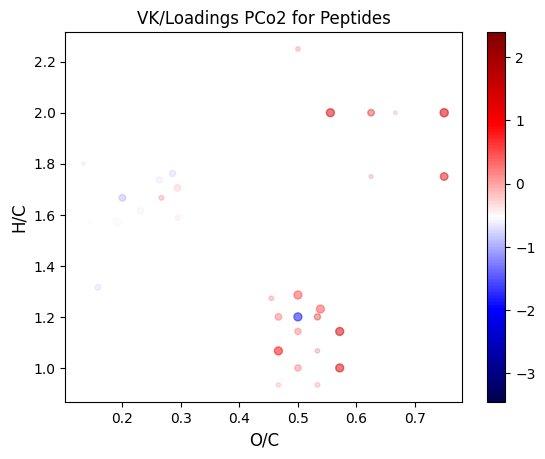

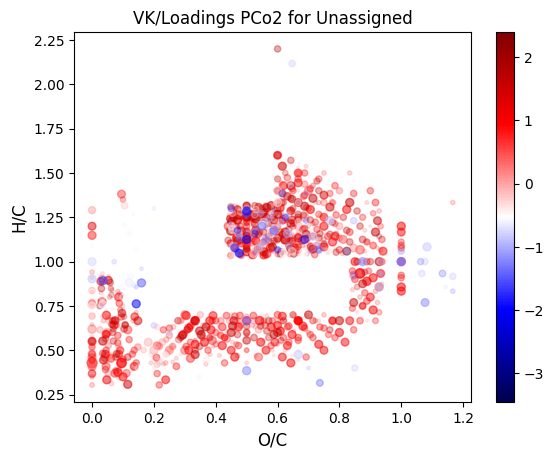

In [91]:
for PCo in chosen_PCos:

    chosen_loadings = loadings[:,PCo-1]
    # chosen_loadings = chosen_loadings[np.where((chosen_loadings>1.5)|
    #                                            (chosen_loadings<-1.5))]
    # sorted_loadings = np.sort(chosen_loadings)
    # chosen_loadings = chosen_loadings[np.where(np.isin(chosen_loadings,sorted_loadings[:1000])|
    #                                            np.isin(chosen_loadings,sorted_loadings[-(1000+1):]))]

    # chosen_loadings = chosen_loadings[np.where((chosen_loadings>.5*np.max(chosen_loadings))|
    #                                            (chosen_loadings<.5*np.min(chosen_loadings)))]

    fig_vkload, ax_vkload = plt.subplots()
    loadings_for_order = chosen_loadings.copy()
    if len(np.where(loadings_for_order<0)[0]) > 0:
        loadings_for_order[np.where(loadings_for_order<0)] /= -np.min(loadings_for_order[np.where(loadings_for_order<0)])
    if len(np.where(loadings_for_order>0)[0]) > 0:
        loadings_for_order[np.where(loadings_for_order>0)] /= np.max(loadings_for_order[np.where(loadings_for_order>0)])

    s = loadings_for_order.copy()
    s_idx = np.arange(len(s))

    if len(np.where(loadings_for_order<0)[0]) > 0 and len(np.where(loadings_for_order>0)[0]) > 0:
        if len((np.where(loadings_for_order<0))[0]) >= len((np.where(loadings_for_order>0))[0]):
            loadings_for_order[np.where(loadings_for_order<0)] /= 100000
        else: loadings_for_order[np.where(loadings_for_order>0)] /= 100000

    order = np.argsort(np.abs(loadings_for_order))
    ordered_loadings = chosen_loadings[order]
    s = np.abs(40*s[order])
    alphas = .8* s / np.max(s)

    mappable = msf.vk_diagram(elems_df.loc[order],c=ordered_loadings,ax=ax_vkload,cmap='seismic',alpha=alphas,marker='o',s=s)
    cbar = fig_vkload.colorbar(mappable)
    cbar.set_label(f'PCo{PCo} Loadings')
    ax_vkload.set_title(f'Van Krevelen Plots Coloured by PCo{PCo} Loadings')

    norm = colors.Normalize(vmin=np.min(chosen_loadings), vmax=np.max(chosen_loadings))

    fig_vkload.savefig(f'plots/pcoa_plots/vk_loadings_pco{PCo}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


    for mclass in molecclass_dict:
        fig_mclass, ax_mclass = plt.subplots()

        idx = list(molecclass_dict[mclass].index)

        order_mclass = [x for x in order if x in idx]
        s_mclass = s[order_mclass] * ( (np.max(ax_vkload.get_xlim())-np.min(ax_vkload.get_xlim())) / (np.max(ax_mclass.get_xlim())-np.min(ax_mclass.get_xlim())) )
        alphas_mclass = alphas[order_mclass]

        mappable =msf.vk_diagram(elems_df.loc[order_mclass],c=chosen_loadings[order_mclass],cmap='seismic',alpha=alphas_mclass,marker='o',ax=ax_mclass,s=s_mclass,norm=norm)
        cbar = fig_mclass.colorbar(mappable)
        ax_mclass.set_title(f'VK/Loadings PCo{PCo} for {mclass}')
        # ax_mclass.set_xlim(ax_vkload.get_xlim())
        # ax_mclass.set_ylim(ax_vkload.get_ylim())

    #     print(F'Avg PCo{PCo} of {mclass} = {np.mean(chosen_loadings[molecclass_dict[mclass].index])} +/- {np.std(chosen_loadings[molecclass_dict[mclass].index])}')


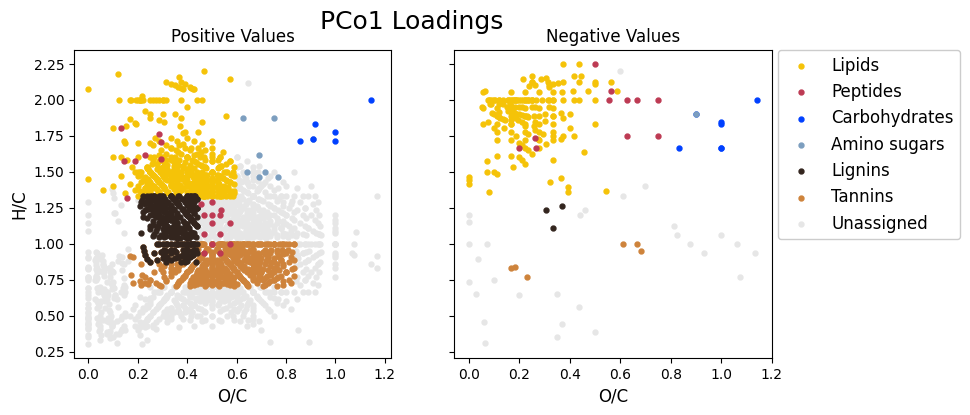

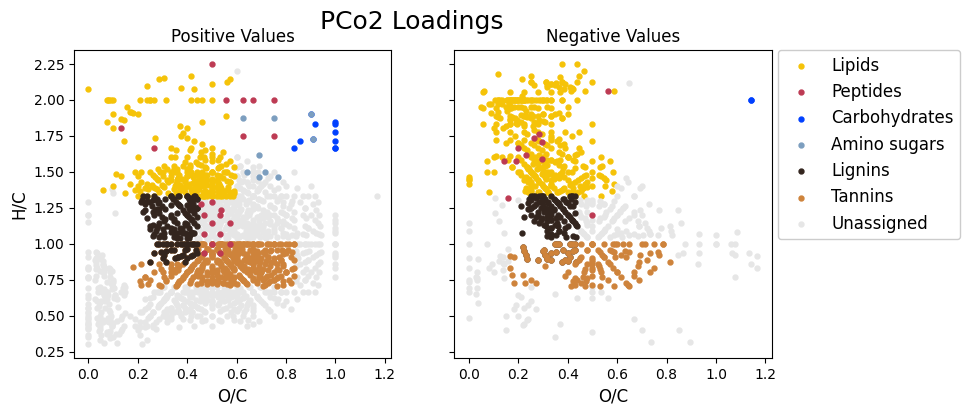

In [92]:
# make 2 plots to show which are increasing and which decreasing

signs = ['positive','negative']
for PCo in chosen_PCos:

    chosen_loadings = loadings[:,PCo-1]

    idxs = [np.where(chosen_loadings>0),np.where(chosen_loadings<0)]
    fig_vkl, ax_vkl = plt.subplots(1,len(idxs),sharey=True,figsize=(9, 4))

    fig_vkl.suptitle(f'PCo{PCo} Loadings',fontsize=18)

    for i in range(len(idxs)):
        # elems_df_pos = elems_df.loc[np.where(chosen_loadings>0)]
        if i == 0: legend = False
        else: legend = True

        # msf.vk_molecclass(elems_df.loc[idxs[i]],ax=ax_vkl[i],legend=legend)

        # msf.density_vk_diagram(elems_df.loc[idxs[i]].reset_index(),ax=ax_vkl[i],fig=fig_vkl,cbar=0)

        x = elems_df.loc[idxs[i]]['O/C']
        y = elems_df.loc[idxs[i]]['H/C']

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        msf.vk_molecclass(elems_df.loc[idxs[i]],ax=ax_vkl[i],legend=legend,s=50)

        ax_vkl[i].set_title(f'{signs[i].capitalize()} Values')

        if i != 0: ax_vkl[i].set_ylabel('')

    fig_vkl.savefig(f'plots/pcoa_plots/vk_2loadings_pco{PCo}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


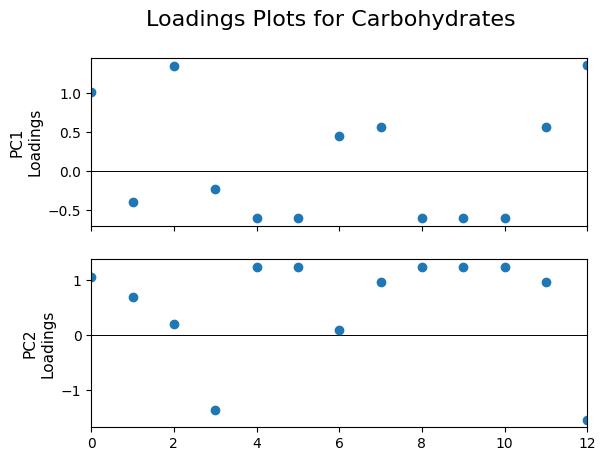

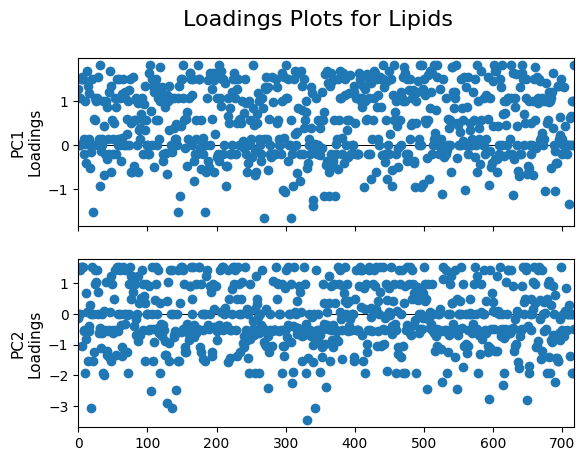

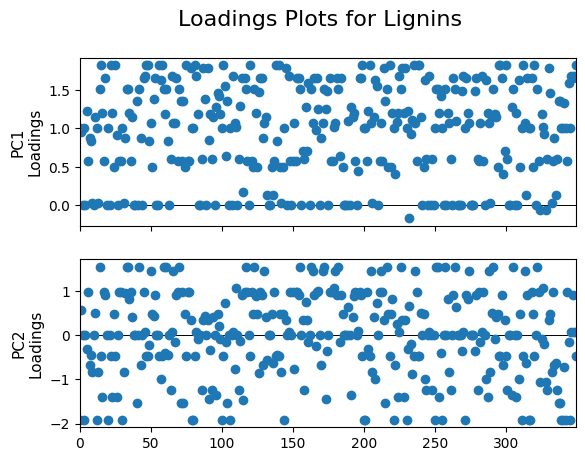

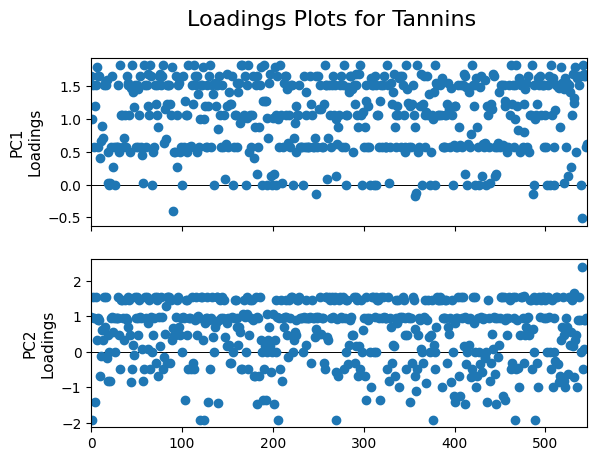

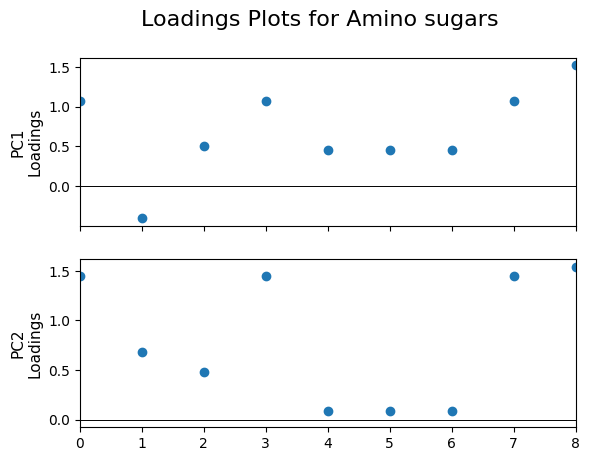

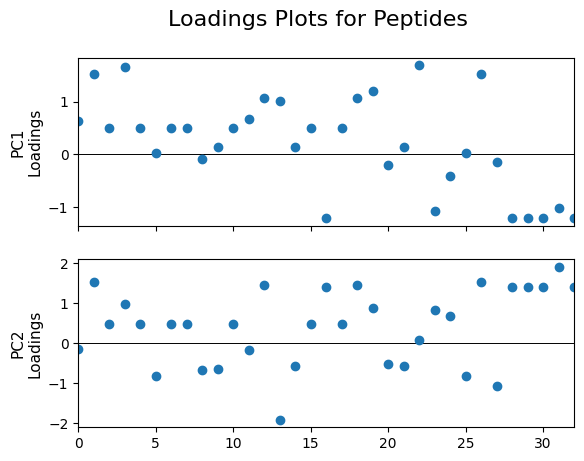

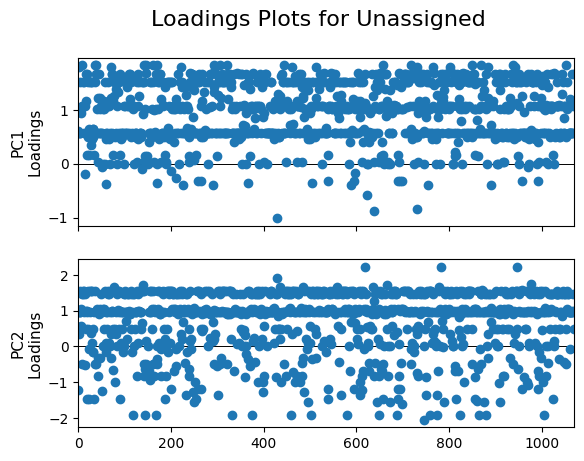

In [93]:
for mclass in molecclass_dict:
    idx = list(molecclass_dict[mclass].index)
    # molecs = [msf.LatexMolecFormula(x) for x in molecclass_dict[mclass]['formulae'].to_list()]
    fig_mclass = plt.figure()
    ax_mclass = fig_mclass.subplots(len(chosen_PCos),sharex=True)
    
    pcf.loadings_plot(np.arange(len(idx)),loadings[idx],chosen_PCos,linestyle='',ax=ax_mclass,fig=fig_mclass,
                      marker='o',text_rotation=90,title=f'Loadings Plots for {mclass}')

In [94]:
sum_norm_ord_table_HM = sum_norm_ord_table_arr[np.where(sample_info['Site'] == 'HM')]
ord_table_arr_HM = ord_table_arr[np.where(sample_info['Site'] == 'HM')]
seasons_HM = np.array([x.split('-')[-1] for x in sample_names if x.startswith('HM-')])
sum_norm_ord_table_AM = sum_norm_ord_table_arr[np.where(sample_info['Site'] == 'AM')]
ord_table_arr_AM = ord_table_arr[np.where(sample_info['Site'] == 'AM')]
seasons_AM = np.array([x.split('-')[-1] for x in sample_names if x.startswith('AM-')])

BC_matrix_HM = BrayCurtis_diss_matr(sum_norm_ord_table_HM)
BC_matrix_AM = BrayCurtis_diss_matr(sum_norm_ord_table_AM)

In [95]:
eigvals_HM, _, loadings_HM, coordinates_HM, proportion_explained_HM = mvf.PCoA(BC_matrix_HM,ord_table_arr_HM,number_of_dimensions=5)
eigvals_AM, _, loadings_AM, coordinates_AM, proportion_explained_AM = mvf.PCoA(BC_matrix_AM,ord_table_arr_AM,number_of_dimensions=5)

In [96]:
D = BC_matrix_HM.copy()
W = mvf.double_centering(D)
eigvals, eigvecs = la.eigh(W)

if np.any(eigvals < 0):
    c1 = np.max(np.abs(eigvals[np.where(eigvals<0)]))
    for i in range(np.shape(D)[0]):
        for j in range(np.shape(D)[1]):
            if i != j: D[i,j] = np.sqrt(np.pow(D[i,j],2)+(2*c1))
    W = mvf.double_centering(D)
    eigvals, eigvecs = la.eigh(W)

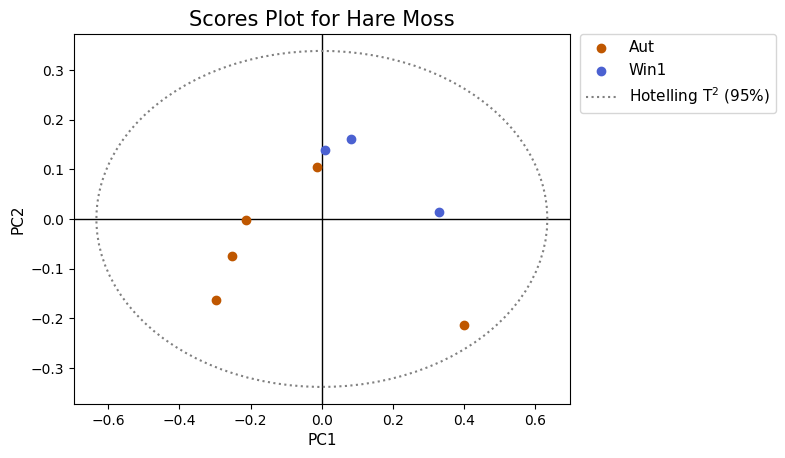

In [97]:
fig_scores, ax_scores = plt.subplots()

for season in np.unique(seasons_HM):

    idx = np.where(seasons_HM == season)

    pcf.scores_plot(coordinates_HM[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape['Hare Moss'],
                    c=seasonal_colours[season],label=season)
        
pcf.Hotelling(coordinates_HM,chosen_PCos,ax_scores)

ax_scores.set_title(f'Scores Plot for Hare Moss',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

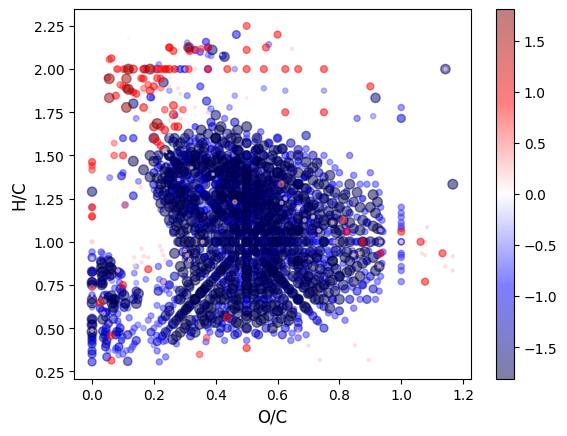

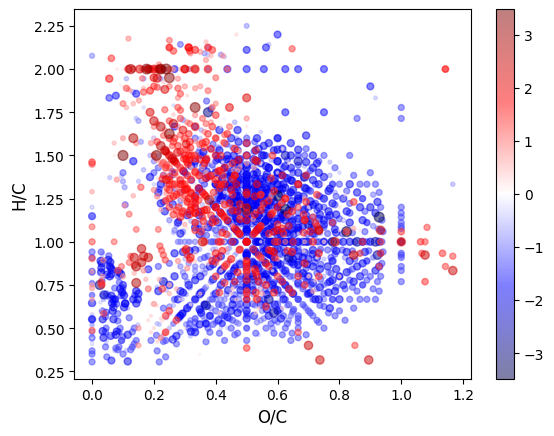

In [98]:
for PCo in chosen_PCos:

    chosen_loadings = loadings_HM[:,PCo-1]

    # idx_to_consider = np.where((chosen_loadings>np.quantile(chosen_loadings[np.where(chosen_loadings>0)],.8))|
    #                            (chosen_loadings<np.quantile(chosen_loadings[np.where(chosen_loadings<0)],.8)))

    # chosen_loadings = chosen_loadings[idx_to_consider]

    fig, ax = plt.subplots()
    loadings_for_order = chosen_loadings.copy()
    loadings_for_order[np.where(loadings_for_order<0)] /= -np.min(loadings_for_order[np.where(loadings_for_order<0)])
    loadings_for_order[np.where(loadings_for_order>0)] /= np.max(loadings_for_order[np.where(loadings_for_order>0)])

    s = loadings_for_order.copy()

    if len((np.where(loadings_for_order<0))[0]) >= len((np.where(loadings_for_order>0))[0]):
        loadings_for_order[np.where(loadings_for_order<0)] /= 100000
    else: loadings_for_order[np.where(loadings_for_order>0)] /= 100000

    order = np.argsort(np.abs(loadings_for_order))
    ordered_loadings = chosen_loadings[order]
    s = np.abs(50*s[order])

    mappable = msf.vk_diagram(elems_df.loc[order],c=ordered_loadings,ax=ax,cmap='seismic',alpha=.5,marker='o',s=s)
    cbar = fig.colorbar(mappable)

    # for mclass in molecclass_dict:
    #     print(F'Avg PCo{PCo} of {mclass} = {np.mean(chosen_loadings[molecclass_dict[mclass].index])} +/- {np.std(chosen_loadings[molecclass_dict[mclass].index])}')

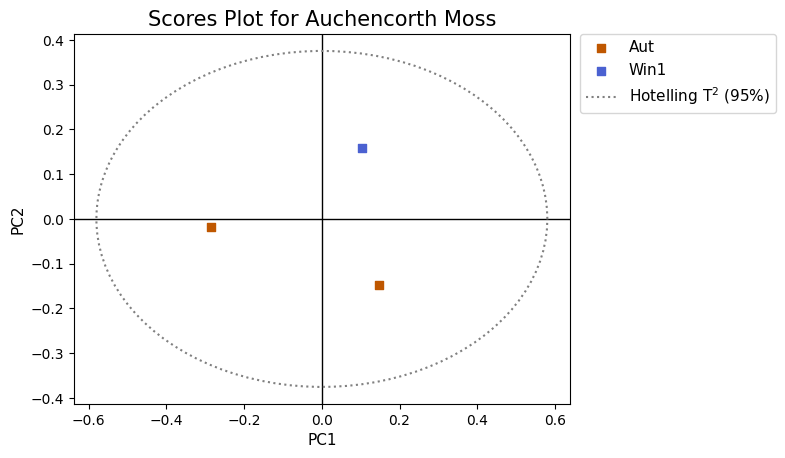

In [99]:
fig_scores, ax_scores = plt.subplots()

for season in np.unique(seasons_AM):

    idx = np.where(seasons_AM == season)

    pcf.scores_plot(coordinates_AM[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape['Auchencorth Moss'],
                    c=seasonal_colours[season],label=season)
        
pcf.Hotelling(coordinates_AM,chosen_PCos,ax_scores)

ax_scores.set_title(f'Scores Plot for Auchencorth Moss',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)